**This notebook is for evaluation of scAR on internal CROPseq data.**

This data has been approved in the manuscript (OAK ID: 46483).
___

Import packages
==

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
from scipy import stats
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted, ns
import scanpy as sc
import numba
import anndata as ad
from sklearn.metrics import r2_score
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.5 umap==0.4.6 numpy==1.21.4 scipy==1.6.2 pandas==1.3.2 scikit-learn==1.0.1 statsmodels==0.12.1 python-igraph==0.9.1 louvain==0.6.1 leidenalg==0.8.3


Plot setting
==

In [3]:
#publication quality plots
from matplotlib import pylab

params = {'legend.fontsize': 5,
          'figure.facecolor':"w",
          'figure.figsize': (3, 2),
          'axes.labelsize': 6,
          'axes.titlesize': 6,
         'axes.linewidth': 0.5,
         'xtick.labelsize': 5,
         'ytick.labelsize': 5,
          # set tick width
          'xtick.major.size': 3.5,
          'xtick.major.width': 0.5,
          'xtick.minor.size': 2,
          'xtick.minor.width': 0.5,
          'xtick.color': 'black',
          'ytick.major.size': 3.5,
          'ytick.major.width': 0.5,
          'ytick.minor.size': 2,
          'ytick.minor.width': 0.5,
          'ytick.color': 'black',
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":200}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10});
pylab.rc('font',**{'family':'sans-serif','sans-serif':['Arial'], 'size':6})

# Set the font used for MathJax - more on this later
# pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

<Figure size 600x400 with 0 Axes>

Metadata
====

In [4]:
metadata_folder = "/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/metadata/"
analysis_out = "/da/onc/BFx/research/shengca1/bioinfo_pipeline/manuscript/analysis/"

indir = "/da/onc/bfx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/"
metadata_folder = "/da/onc/bfx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/metadata/"
metadata = pd.read_csv(metadata_folder + "sample_annotation.csv", header=0, index_col=0)
metadata = metadata[["cell_type","condition1","condition2","grna_library","grna_enrPCR"]]

# sample_metadata = pd.read_csv(metadata_folder + "sample_metadata.csv", header=0)
# metadata=pd.DataFrame()

metadata["condition1"] = ["D"+cdt1.split("D")[0] for cdt1 in metadata["condition1"]]
metadata["condition1"] = pd.Categorical(metadata["condition1"], ordered=True, categories= natsorted(metadata["condition1"].unique()))
metadata =metadata.sort_values(['condition1','condition2'])

metadata["sgrna_kallisto"]=[indir+f"kallisto_bus_CROP-seq_pilot/{pcr}/sgRNA_output/sgRNA_assigned_to_BC.pickle" for pcr in metadata["grna_enrPCR"]]
metadata["sgrna_fullalign"]=[indir+f"cellranger_count_CROP-seq_pilot/{pcr}/sgRNA_output/sgRNA_assigned_to_BC.pickle" for pcr in metadata["grna_enrPCR"]]
metadata["filtered_feature_bc_matrix"]=[indir+f"/cellranger_count/{sample}/outs/filtered_feature_bc_matrix/" for sample in metadata.index]
metadata["raw_feature_bc_matrix"]=[indir+f"/cellranger_count/{sample}/outs/raw_feature_bc_matrix/" for sample in metadata.index]
metadata["path_kallisto"]=[indir+f"/kallisto_bus_homo_sapiens_release-98_cdna.premrnaPolyAT/{sample}/h5ad_output/genelevel.h5ad" for sample in metadata.index]
metadata["path_kallisto_sgRNA"]=[indir+f"/kallisto_bus_homo_sapiens_release-98_cdna.premrnaPolyAT/{sample}/h5ad_output/genelevel_sgRNAs_agg.h5ad" for sample in metadata.index]

metadata['scAR_out']=[os.path.join('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CROPseq/cropseq_val/scAR_out',sample) for sample in metadata.index]
metadata['TensorBoard']=['/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CROPseq/cropseq_val/TensorBoard/'+sample for sample in metadata.index]
metadata['scAR_out_mRNA']=[os.path.join('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CROPseq/cropseq_val/scAR_out_mRNA',sample) for sample in metadata.index]
metadata['TensorBoard_mRNA']=['/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CROPseq/cropseq_val/TensorBoard_mRNA/'+sample for sample in metadata.index]

metadata['sample'] = metadata.index

metadata['count_matrix'] = [f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/{sample}_raw_counts_sgRNAs.pickle' for sample in metadata.index]
metadata['empty_profile'] = [f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/{sample}_empty_profile.pickle' for sample in metadata.index]
metadata['count_matrix_mRNA'] = [f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/{sample}_raw_counts_mRNAs.pickle' for sample in metadata.index]
metadata['empty_profile_mRNA'] = [f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/{sample}_empty_profile_mRNA.pickle' for sample in metadata.index]

metadata['hard_filter']=[f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/CROPseq/cropseq_val/{sample}_hard_filter.pickle' for sample in metadata.index]
metadata = metadata[metadata["condition1"].isin(["D5","D12"])]
metadata

,cell_type,condition1,condition2,grna_library,grna_enrPCR,sgrna_kallisto,sgrna_fullalign,filtered_feature_bc_matrix,raw_feature_bc_matrix,path_kallisto,...,scAR_out,TensorBoard,scAR_out_mRNA,TensorBoard_mRNA,sample,count_matrix,empty_profile,count_matrix_mRNA,empty_profile_mRNA,hard_filter
sample_name,,,,,,,,,,,,,,,,,,,,,
OE-41-LX17,MCF7,D5,R1,CROP-seq_pilot,OE-41-LX17,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,OE-41-LX17,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...
KE-42-LB17,MCF7,D5,R2,CROP-seq_pilot,KE-42-LB17,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,KE-42-LB17,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...
SF-40-AP15,MCF7,D12,R1,CROP-seq_pilot,SF-40-AP15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,SF-40-AP15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...
OF-40-AT15,MCF7,D12,R2,CROP-seq_pilot,OF-40-AT15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,OF-40-AT15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...
KF-40-AX15,MCF7,D12,R3,CROP-seq_pilot,KF-40-AX15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,KF-40-AX15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/

In [5]:
guide_metadata = pd.read_csv(metadata_folder + "guide_metadata_final.csv", header=0,index_col=0)
guide_metadata.head()

,grna_library,groups,grna_number,target_genes,length,ensembl,sgRNAs
sequence,,,,,,,
AGTTCCGACGCCACTGAGAG,CROP-seq_pilot,CDH1,1,CDH1,20.0,ENSG00000105325,CDH1_g1
GACTTGCGAGGGACGCATTC,CROP-seq_pilot,CDH1,2,CDH1,20.0,ENSG00000105325,CDH1_g2
CCGAGAGGCTGCGGCTCCAA,CROP-seq_pilot,CDH1,3,CDH1,20.0,ENSG00000105325,CDH1_g3
CGGTGACGACGGGAGAGGAA,CROP-seq_pilot,CDH1,4,CDH1,20.0,ENSG00000105325,CDH1_g4
CCTCAGGACCCGAACTTTCT,CROP-seq_pilot,CDH1,5,CDH1,20.0,ENSG00000105325,CDH1_g5


Analysis of sgRNA frequencies
==

Pooled dropout experiment
--

In [6]:
# Dropout results, generated from "/da/ONC/BFx/research/shengca1/bioinfo_pipeline/manuscript/manuscript.ipynb"
dropout_results = pd.read_csv("/da/ONC/BFx/research/shengca1/pipeline/obfx-pooledscreen/Counts (log and raw)_dropout.csv",header=0,index_col=0)
dropout_results.drop_duplicates(inplace=True)
dropout_results.drop(columns=["norm. counts"],inplace=True)
dropout_results=dropout_results.groupby(["groups","sgRNAs","time point"]).mean().unstack()
dropout_results.columns=dropout_results.columns.droplevel()
dropout_results.index=dropout_results.index.droplevel()

In [7]:
dropout_results.head()

time point,D0,D12,D5,D7,D9
sgRNAs,,,,,
CCND1_g1,1.483894e+06,2.856694e+05,1.025650e+06,7.616251e+05,3.967361e+05
CCND1_g2,5.790630e+05,2.951999e+05,3.956340e+05,3.121429e+05,2.836126e+05
CCND1_g3,4.466563e+06,3.684461e+06,3.682836e+06,3.483920e+06,3.411182e+06
CCND1_g4,1.853107e+06,1.243662e+06,1.622464e+06,1.281166e+06,1.401186e+06
CDH1_g1,1.861454e+06,1.908927e+06,1.892275e+06,1.711968e+06,1.756939e+06


time point,D0,D12,D5,D7,D9
time point,,,,,
D0,1.000000,0.898843,0.984042,0.967482,0.936898
D12,0.898843,1.000000,0.941448,0.970105,0.989240
D5,0.984042,0.941448,1.000000,0.990093,0.973715
D7,0.967482,0.970105,0.990093,1.000000,0.990501
D9,0.936898,0.989240,0.973715,0.990501,1.000000


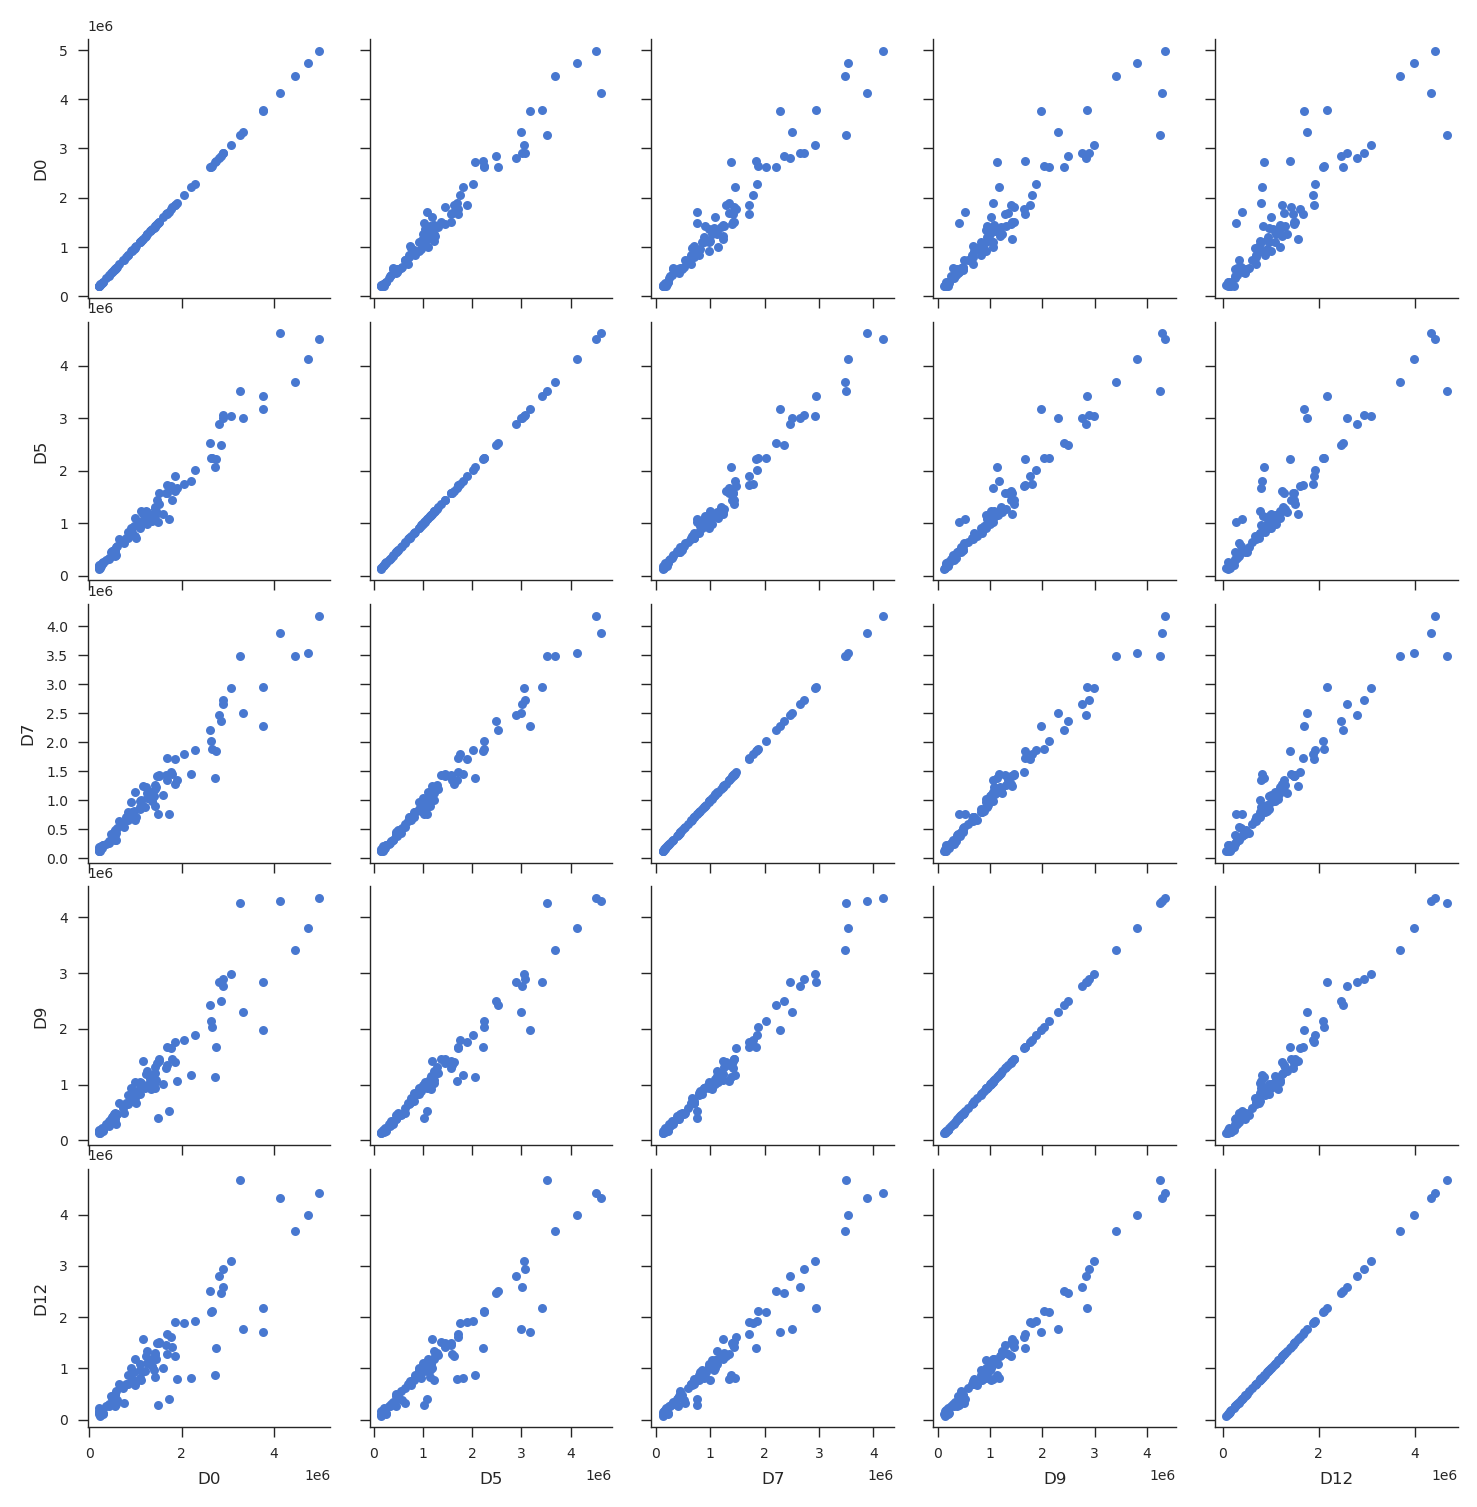

In [8]:
g = sns.PairGrid(dropout_results, vars=["D0", "D5", "D7", "D9", "D12"],height=1.5, aspect=1)
g.map(plt.scatter,s=5);
dropout_results.corr(method='pearson')

sgRNA frequencies in empty droplets
--

In [9]:
def ambient_profile(raw_sgRNA_counts, filtered_adata, avg=True):
    
    cell_CBs = [cb.split('-')[0] for cb in filtered_adata.obs_names]  # CBs of cell containing droplets
    empty_CBs = raw_sgRNA_counts.index.difference(cell_CBs)  # CBs of empty droplets
    empty_droplets = raw_sgRNA_counts.loc[empty_CBs] # empty droplets
    empty_droplets.drop(columns=['Cas9_blast'], inplace=True)  # drop Cas9 counts
    
    if avg:
        return empty_droplets.sum()/empty_droplets.sum().sum()
    else:
        return empty_droplets.sum()

In [10]:
empty_profile_all = pd.DataFrame()

for sample, row in metadata.iterrows():
    
    empty_profile = pd.read_pickle(row['empty_profile'])
    empty_profile.columns = ['CROPseq_emptyDroplets']
    empty_profile['samples'] = row['condition1']+row['condition2']
    empty_profile_all = empty_profile.append(empty_profile_all)
    
    print(sample, ' done!')
    
empty_profile_all['time_points'] = [tp.split('R')[0] for tp in empty_profile_all['samples']]
empty_profile_all = empty_profile_all.rename_axis('sgRNAs').reset_index()
empty_profile_avg = empty_profile_all.groupby(['time_points','sgRNAs']).mean()

OE-41-LX17  done!
KE-42-LB17  done!
SF-40-AP15  done!
OF-40-AT15  done!
KF-40-AX15  done!


In [11]:
pool_freq = dropout_results/dropout_results.sum()
pool_freq_stacked = pool_freq.stack().to_frame('cell pool').rename_axis(['sgRNAs', 'time_points'])
pool_freq_stacked = pool_freq_stacked.reorder_levels(['time_points', 'sgRNAs'])
pool_freq_stacked.drop(index=['D0', 'D7', 'D9'], inplace=True)

sgRNA_freq = pool_freq_stacked.join(empty_profile_avg, how='left')

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [12]:
sgRNA_freq['R2_score'] = 0
for tp in ['D5', 'D12']:
    sgRNA_freq.loc[tp, 'R2_score'] = r2_score(sgRNA_freq.loc[tp, 'cell pool'], sgRNA_freq.loc[tp, 'CROPseq_emptyDroplets'])
sgRNA_freq = sgRNA_freq.reset_index()

In [13]:
R2 = dict(sgRNA_freq[['time_points', 'R2_score']].drop_duplicates().values)

Text(0, 0.035, 'R2: 0.933')

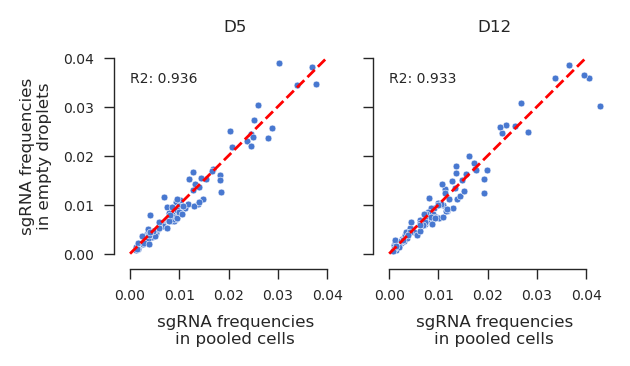

In [14]:
g = sns.relplot(data=sgRNA_freq,
                x="cell pool",
                y="CROPseq_emptyDroplets",
                col="time_points",
                col_order=['D5', 'D12'],
                kind="scatter",
                aspect=0.9,
                height=1.7,
                s=6
               );

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=2, trim=True);

g.set_titles('{col_name}');
[ax.plot([0, 0.04], [0, 0.04], ls='--', linewidth=1, color='red') for ax in g.axes.flatten()];

g.set(xlabel='sgRNA frequencies\nin pooled cells', ylabel='sgRNA frequencies\nin empty droplets')
g.axes[0,0].text(0, 0.035, f"R2: {R2['D5']:.03f}", size=5)
g.axes[0,1].text(0, 0.035, f"R2: {R2['D12']:.03f}", size=5)

# g.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/sgRNA_corr_btw_empty_pool.pdf')

sgRNA detection
==

number of sgRNA per cell
--

In [15]:
num_sgRNAs_per_cell_all = pd.DataFrame()

for sample, row in metadata.iterrows():
    
    print(f"\n========Processing {sample} ......======")
    adata = sc.read_10x_mtx(row["filtered_feature_bc_matrix"])
    sgRNA_assign = pd.read_pickle(row["sgrna_kallisto"])

    cell_barcodes = adata.obs_names.to_frame()
    cell_barcodes.index = [idx.split('-')[0] for idx in cell_barcodes.index]
    raw_sgRNA_cells = cell_barcodes.join(sgRNA_assign, how='left')
    raw_sgRNA_cells.drop(columns=['Cas9_blast', 0], inplace=True)
    num_sgRNAs_per_cell = (raw_sgRNA_cells>0).sum(axis=1)
    num_sgRNAs_per_cell = num_sgRNAs_per_cell.to_frame('n_sgRNAs_per_cell')
    num_sgRNAs_per_cell['time_points'] = row['condition1']
    num_sgRNAs_per_cell['condition2'] = row['condition2']

    num_sgRNAs_per_cell_all = num_sgRNAs_per_cell.append(num_sgRNAs_per_cell_all)
    
    print(sample, ' done!')


========Processing OE-41-LX17 ......======
OE-41-LX17  done!

========Processing KE-42-LB17 ......======
KE-42-LB17  done!

========Processing SF-40-AP15 ......======
SF-40-AP15  done!

========Processing OF-40-AT15 ......======
OF-40-AT15  done!

========Processing KF-40-AX15 ......======
KF-40-AX15  done!


[(0.0, 0.037)]

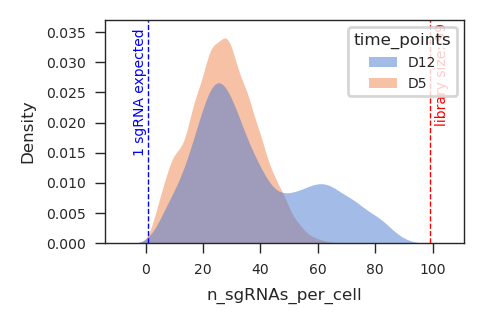

In [16]:
plt.figure(figsize=(2.4, 1.6))
ax = sns.kdeplot(data=num_sgRNAs_per_cell_all.reset_index(),
            x="n_sgRNAs_per_cell",
            hue="time_points",
            fill=True, 
            common_norm=False, 
            alpha=.5,
            linewidth=0,
           );
ax.vlines(x=99, ymin=0, ymax=0.037, ls='--', color='red', lw=0.5);
ax.text(101, 0.02, 'library size: 99', color='r', size=5, rotation=90)
ax.vlines(x=1, ymin=0, ymax=0.037, ls='--', color='blue', lw=0.5);
ax.text(-4.5, 0.015, '1 sgRNA expected', color='blue', size=5, rotation=90)
ax.set(ylim=(0, 0.037))
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/num_sgRNA_per_cell.pdf')

# Denoising mRNA

In [17]:
def deterimine_empty_droplets(adata_raw, adata_filtered, sample, threshold=30):
    
    rank_UMIs = pd.DataFrame(adata_raw.X.sum(axis=1), index = adata_raw.obs_names, columns=['total_counts'])
    rank_UMIs['droplets'] = 'cell-free droplets'
    rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>threshold, 'other droplets')
    rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs.index.isin(adata_filtered.obs_names), 'cells')
    rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
    rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
    
    fig = plt.figure(figsize=(3,2))

    ax = sns.lineplot(data = rank_UMIs,
                 x='rank',
                 y='total_counts',
                 hue='droplets',
                 markers=False,
                 lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('sorted droplet')
    ax.legend(loc='upper right', ncol=1, title=None, frameon=False)
    ax.set_title(f'kneeplot: {sample}')

    sns.set_palette("muted")
    sns.set_style("ticks")
    sns.despine(offset=10, trim=False);

    plt.show()
    return rank_UMIs.loc[rank_UMIs['droplets'] == 'cell-free droplets', 'index']

In [18]:
emp_cutoff = dict({'OE-41-LX17': 70,
                   'KE-42-LB17': 300,
                   'SF-40-AP15': 80,
                   'OF-40-AT15': 70,
                   'KF-40-AX15': 200,
                  })

In [19]:
try:
    metadata = metadata.join(pd.DataFrame.from_dict(emp_cutoff, orient='index', columns=['cutoff_empty_droplets']))
except:
    metadata['cutoff_empty_droplets'] = pd.DataFrame.from_dict(emp_cutoff, orient='index', columns=['cutoff_empty_droplets'])

In [20]:
metadata

,cell_type,condition1,condition2,grna_library,grna_enrPCR,sgrna_kallisto,sgrna_fullalign,filtered_feature_bc_matrix,raw_feature_bc_matrix,path_kallisto,...,TensorBoard,scAR_out_mRNA,TensorBoard_mRNA,sample,count_matrix,empty_profile,count_matrix_mRNA,empty_profile_mRNA,hard_filter,cutoff_empty_droplets
sample_name,,,,,,,,,,,,,,,,,,,,,
OE-41-LX17,MCF7,D5,R1,CROP-seq_pilot,OE-41-LX17,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,OE-41-LX17,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,70
KE-42-LB17,MCF7,D5,R2,CROP-seq_pilot,KE-42-LB17,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,KE-42-LB17,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,300
SF-40-AP15,MCF7,D12,R1,CROP-seq_pilot,SF-40-AP15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,SF-40-AP15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,80
OF-40-AT15,MCF7,D12,R2,CROP-seq_pilot,OF-40-AT15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,OF-40-AT15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,70
KF-40-AX15,MCF7,D12,R3,CROP-seq_pilot,KF-40-AX15,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,KF-40-AX15,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,/da/ONC/BFx/research/shengca1/pipeline/obfx-fb...,200


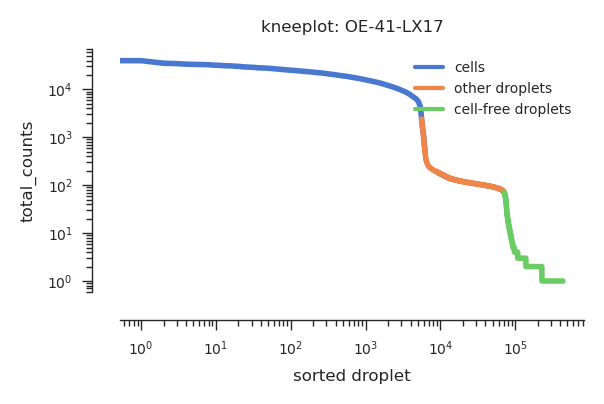

OE-41-LX17  done!


In [21]:
for sample,row in metadata.iterrows():

    adata_raw = sc.read_10x_mtx(row['raw_feature_bc_matrix'], cache=True)
    adata_filtered = sc.read_10x_mtx(row['filtered_feature_bc_matrix'], cache=True)

    count_matrix = adata_filtered.to_df()
    adata_raw = adata_raw[:, adata_filtered.var_names]

    empty_droplets_cb = deterimine_empty_droplets(adata_raw, adata_filtered, sample, threshold=row['cutoff_empty_droplets'])
    empty_droplets = adata_raw[empty_droplets_cb][:, count_matrix.columns]
    empty_profile = pd.DataFrame(empty_droplets.X.sum(axis=0)/empty_droplets.X.sum(), columns=empty_droplets.var_names).T

    # Sanity check the columns
    assert (empty_profile.index == count_matrix.columns).all()

    # save files
    count_matrix.to_pickle(row['count_matrix_mRNA'])
    empty_profile.to_pickle(row['empty_profile_mRNA'])
    print(sample, ' done!')
    break

In [22]:
sgRNA_freq

,time_points,sgRNAs,cell pool,CROPseq_emptyDroplets,R2_score
0,D12,CCND1_g1,0.002613,0.002998,0.932642
1,D5,CCND1_g1,0.008398,0.007080,0.935772
2,D12,CCND1_g2,0.002700,0.002318,0.932642
3,D5,CCND1_g2,0.003239,0.003846,0.935772
4,D12,CCND1_g3,0.033702,0.035869,0.932642
...,...,...,...,...,...
177,D5,enh588_g4,0.020378,0.025107,0.935772
178,D12,enh588_g5,0.003887,0.003817,0.932642
179,D5,enh588_g5,0.003851,0.002066,0.935772
180,D12,enh588_g6,0.006259,0.005939,0.932642


In [24]:
cell_pool = sgRNA_freq.set_index(['time_points', 'sgRNAs']).loc['D12', 'cell pool'].sort_index()

empty_droplet_in_fb = sgRNA_assign.loc[~sgRNA_assign.index.isin(empty_droplets_cb) & ~sgRNA_assign.index.isin(cell_barcodes)]
sgRNA_assign = pd.read_pickle(row["sgrna_kallisto"])
sgRNA_assign.drop(columns=['Cas9_blast'], inplace=True)
sgRNA_assign.index = sgRNA_assign.index.astype(str)+'-1'

sgRNA_assign = sgRNA_assign[sgRNA_assign.sum(axis=1)>0]
sgRNA_assign = sgRNA_assign.loc[:, sgRNA_assign.columns.isin(cell_pool.index)]

sample_frac = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
freq_fb = pd.DataFrame(columns=sgRNA_assign.columns, index=sample_frac)

cell_droplets = sgRNA_assign.loc[sgRNA_assign.index.isin(cell_barcodes)].sum()
freq_fb.loc['cells']=cell_droplets/cell_droplets.sum()


r2_score_df =pd.DataFrame(index=pd.MultiIndex.from_product([range(1,11), sample_frac]), columns=['R2_score'])

for n_random in range(1,11):
    for frac in sample_frac:
        sampled_empty_fb = empty_droplet_in_fb.sample(frac=frac, axis=0)
        sampled_droplets = sgRNA_assign.loc[sgRNA_assign.index.isin(sampled_empty_fb.index)].sum()
        freq_fb.loc[frac]=sampled_droplets/sampled_droplets.sum()

        r2_score_df.loc[(n_random, frac)] = r2_score(cell_pool, freq_fb.loc[frac].sort_index())#freq_fb.loc['cells']
        if n_random == 1:
            print(sampled_empty_fb.shape[0])

71
143
214
285
356
428
499
570
641
713


In [25]:
freq_unpivoted = freq_fb.T.melt(id_vars=['cells'], var_name='droplets', value_name='fraction of genes')
freq_unpivoted['fraction of protein counts in cells (%)'] = freq_unpivoted['cells'] * 100
freq_unpivoted['fraction of protein counts in droplets (%)'] = freq_unpivoted['fraction of genes'] * 100

# freq.T.stack().to_frame('fraction').rename_axis(['genes', 'droplets']).reset_index()

In [26]:
r2_score_df = r2_score_df.rename_axis(['runs','proportion of empty droplets']).reset_index()

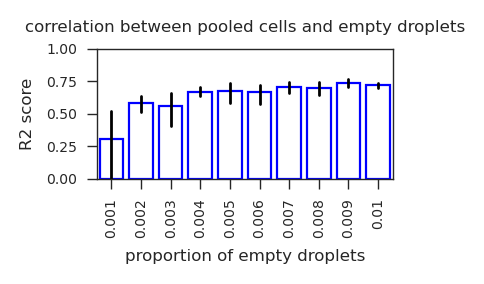

In [27]:
plt.figure(figsize=(2,1.4))
ax = sns.barplot(y='R2_score', x='proportion of empty droplets', data=r2_score_df, errwidth=1, linewidth=.8, facecolor=(1, 1, 1, 0),
                 errcolor="black", edgecolor="blue");
# plt.setp(ax.patches, linewidth=0.1, color='green')
ax.set_title('correlation between pooled cells and empty droplets')
ax.set_ylabel('R2 score')
ax.set_ylim([0,1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/CROP-seq_droplets_cell_correlation_fb_barplot.pdf', doi=200)

Assign sgRNAs
==

In [28]:
import spreen as sn

## hard filtering

In [29]:
for sample, row in metadata.iterrows():
    
    print(f"\n========Processing {sample} ......======")
    adata = sc.read_10x_mtx(row["filtered_feature_bc_matrix"])
    sgRNA_assign = pd.read_pickle(row["sgrna_kallisto"])
    adata.obs["sampleID"] = sample
    sn.pp.integrate_metadata(adata,metadata.rename_axis("sampleID").reset_index(),guide_metadata)
    asgn_hdf = sn.pp.filter_sgRNAs(adata,sgRNA_assign, model="hard_filter",cutoff=[0.01, 3], ambient_from="empty", inplace=False)
    asgn_hdf.to_pickle(row['hard_filter'])
    
    print(f'{sample} done!!!')


========Processing OE-41-LX17 ......======
Cas9_blast is not present
assign sgRNAs to valid cell barcodes...
OE-41-LX17 done!!!

========Processing KE-42-LB17 ......======
Cas9_blast is not present
assign sgRNAs to valid cell barcodes...
KE-42-LB17 done!!!

========Processing SF-40-AP15 ......======
Cas9_blast is not present
assign sgRNAs to valid cell barcodes...
SF-40-AP15 done!!!

========Processing OF-40-AT15 ......======
Cas9_blast is not present
assign sgRNAs to valid cell barcodes...
OF-40-AT15 done!!!

========Processing KF-40-AX15 ......======
Cas9_blast is not present
assign sgRNAs to valid cell barcodes...
KF-40-AX15 done!!!


In [30]:
def assign_fb(sgRNA_counts):
    
    sgRNA_assign = pd.DataFrame(index=sgRNA_counts.index,columns=['sgRNAs', 'n_sgRNAs'])
    for cell, row in sgRNA_counts.iterrows():
        sgRNA_max_exp = row[row==row.max()]
        if row.max()==0:
            sgRNA_assign.loc[cell, 'n_sgRNAs'] = 0
            sgRNA_assign.loc[cell, 'sgRNAs'] = np.nan
        elif len(sgRNA_max_exp)==1:
            sgRNA_assign.loc[cell, 'n_sgRNAs'] = 1
            sgRNA_assign.loc[cell, 'sgRNAs'] = sgRNA_max_exp.index[0]
        else:
            sgRNA_assign.loc[cell, 'n_sgRNAs'] = 2
            sgRNA_assign.loc[cell, 'sgRNAs'] = (', ').join(sgRNA_max_exp.index)
            
    return sgRNA_assign

In [31]:
assignment_fb = pd.DataFrame()

for sample, row in metadata.iterrows():
    
        sgRNA_assign_real_cells = pd.read_pickle(row['count_matrix'])
        sgRNA_assign_naive = assign_fb(sgRNA_assign_real_cells)
        sgRNA_assign_naive['meth'] = 'naive'

        # scar
        scar_pval = pd.read_pickle(os.path.join(row['scAR_out'], 'probs.pickle'))
        # scar_pval[scar_pval<=0.99] = 0  # expected pval below 0.9 considering as ambient signals
        sgRNA_assign_scar = assign_fb(scar_pval)
        sgRNA_assign_scar['meth'] = 'scAR'
        
        tmp = sgRNA_assign_naive.append(sgRNA_assign_scar)#.append(sgRNA_assign_scar_filter).append(sgRNA_assign_hdf)
        tmp['time_points'] = row['condition1']
        tmp['condition2'] = row['condition2']

        assignment_fb = tmp.append(assignment_fb)

assignment_fb.index = assignment_fb['time_points'].astype(str) + '_' + assignment_fb['condition2'].astype(str) + '_' + assignment_fb.index.astype(str) + '-1'
assignment_fb['n_sgRNAs'] = assignment_fb['n_sgRNAs'].astype(int)

sgRNA2gene = dict(guide_metadata[['sgRNAs', 'target_genes']].values)
sgRNA2grp = dict(guide_metadata[['sgRNAs', 'groups']].values)

assignment_fb.loc[:,'target_genes'] = assignment_fb['sgRNAs'].map(sgRNA2gene)
assignment_fb.loc[:,'groups'] = assignment_fb['sgRNAs'].map(sgRNA2grp)

In [32]:
assignment_fb_single = assignment_fb[assignment_fb['n_sgRNAs']==1]
assignment_fb_freq = assignment_fb_single.groupby(['time_points', 'meth', 'sgRNAs']).sum()/assignment_fb_single.groupby(['time_points', 'meth']).sum()

In [33]:
cell_frac = assignment_fb_freq.join(sgRNA_freq.set_index(['time_points', 'sgRNAs'])[['cell pool']])
cell_frac.rename(columns={"n_sgRNAs": "cell fraction"}, inplace=True)

In [34]:
r2_func = lambda grp: r2_score(grp['cell pool'], grp['cell fraction'])
R2_score = cell_frac.fillna(0).reset_index().groupby(by = ['time_points', 'meth']).apply(r2_func)
R2_score

time_points  meth 
D12          naive    0.861023
             scAR     0.912921
D5           naive    0.368814
             scAR     0.875404
dtype: float64

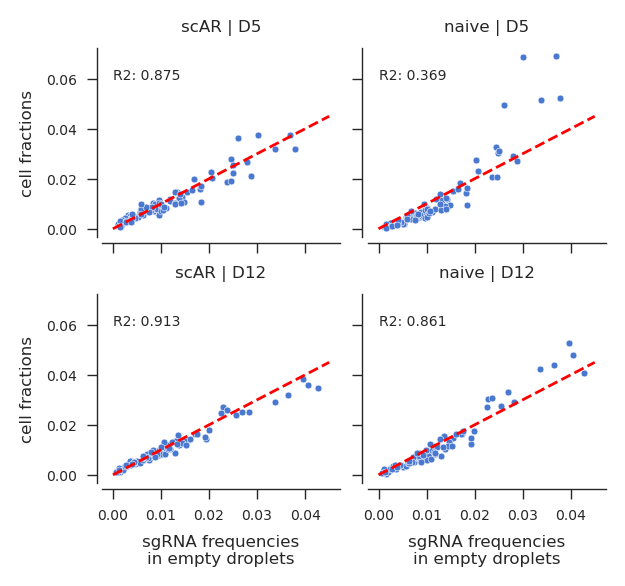

In [35]:
g = sns.relplot(data=cell_frac.reset_index(),
                x="cell pool",
                y="cell fraction",
                col='meth',
                col_order=['scAR', 'naive'], #'scar_filter','hdf', 
                row="time_points",
                row_order=['D5', 'D12'],
                kind="scatter",
                aspect=1.1,
                height=1.4,
                s=6
);

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=2, trim=False);

g.set_titles('{col_name} | {row_name}')
# g.set(xlim=(0,0.12), ylim=(0,0.12))
[ax.plot([0, 0.045], [0, 0.045], ls='--', linewidth=1, color='red') for ax in g.axes.flatten()];

for ax in g.axes.flatten():
    meth, tps = ax.title.get_text().replace(' ','').split('|')
    ax.text(0.00, 0.06, f"R2: {R2_score.loc[tps, meth]:.03f}", size=5)

g.set(ylabel='cell fractions', xlabel='sgRNA frequencies\nin empty droplets')

# g.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/sgRNA_corr_btw_empty_cellfrac_all.pdf')

In [36]:
counts_func = lambda grp: grp[['n_sgRNAs']].value_counts()

num_cell = assignment_fb.groupby(['time_points', 'meth']).apply(counts_func)
num_cell = num_cell.to_frame('cell number')
total_number = assignment_fb.groupby(['time_points', 'meth']).count()
num_cell_pct = num_cell/total_number[['n_sgRNAs']].rename(columns={'n_sgRNAs':'cell number'})

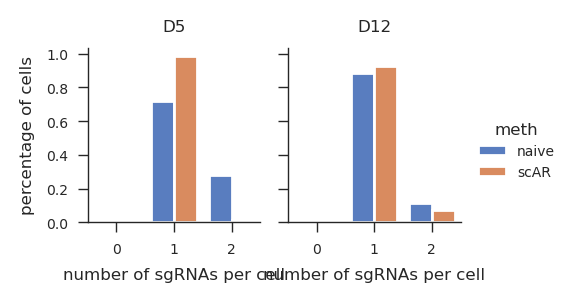

In [37]:
g = sns.catplot(data=num_cell_pct.reset_index(), x='n_sgRNAs', y ='cell number',
                hue='meth', hue_order=['naive', 'scAR'],
                col='time_points',col_order=['D5', 'D12'],
                height=1.5, aspect=0.8,
                kind='bar');
g.set_titles('{col_name}');
g.set(xlabel='number of sgRNAs per cell', ylabel='percentage of cells')
# g.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/cell_percentage_by_number_of_sgRNAs.pdf')

# On-target effect

In [38]:
expression_mat_assignment = pd.DataFrame()

g_list = list(guide_metadata['target_genes'].unique()) + ['DDB2', 'BAX', 'SESN1']

for sample, row in metadata.iterrows():
        adata = sc.read_10x_mtx(row["filtered_feature_bc_matrix"])
        sc.pp.normalize_total(adata, target_sum=1e5, inplace=True)
        sc.pp.log1p(adata)
        exp_mat = adata[:, adata.var_names.intersection(g_list)].to_df()  
        exp_mat['time_points'] = row['condition1']
        exp_mat['replicates'] = row['condition2']
        exp_mat.index = exp_mat['time_points'].astype(str) + '_' + exp_mat['replicates'].astype(str) +  '_' + exp_mat.index.astype(str)
        expression_mat_assignment = exp_mat.append(expression_mat_assignment)
        print(f'{sample} done!!!')

OE-41-LX17 done!!!
KE-42-LB17 done!!!
SF-40-AP15 done!!!
OF-40-AT15 done!!!
KF-40-AX15 done!!!


In [39]:
assignment_fb_single_sgRNA = assignment_fb[assignment_fb['n_sgRNAs']==1]
assignment_fb_single_sgRNA = assignment_fb_single_sgRNA.rename_axis('cells').reset_index().pivot(index='cells',columns=['meth'], values=['sgRNAs', 'groups'])
assignment_fb_single_sgRNA.columns = assignment_fb_single_sgRNA.columns.to_flat_index().str.join('_')

In [40]:
expression_mat_assignment = assignment_fb_single_sgRNA.join(expression_mat_assignment, how='left', rsuffix='_exp')
expression_mat_assignment.to_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/expression_matrix_sgRNA_assigned_wt_library_normalization.pickle')

In [41]:
expression_mat_assignment.head()

,sgRNAs_naive,sgRNAs_scAR,groups_naive,groups_scAR,OR2L13,CXCR4,PIK3CA,SESN1,ESR1,KMT2C,...,YAP1,GATA3,KMT2D,FOXA1,CDH1,TP53,SUZ12,BAX,time_points,replicates
cells,,,,,,,,,,,,,,,,,,,,,
D12_R1_AAACCTGAGAAGGGTA-1,ESR1_TSS2_g4,ESR1_TSS2_g4,ESR1_TSS2,ESR1_TSS2,0.0,0.0,0.0,0.0,0.000000,1.983430,...,0.0,3.260805,0.0,0.000000,1.983430,2.985827,0.000000,2.605298,D12,R1
D12_R1_AAACCTGCACAGTCGC-1,enh588_g4,enh588_g4,enh588,enh588,0.0,0.0,0.0,0.0,2.287824,2.287824,...,0.0,4.494627,0.0,2.928895,3.316381,2.928895,0.000000,3.316381,D12,R1
D12_R1_AAACCTGCACGTCTCT-1,CTRL_g11,CTRL_g11,CTL,CTL,0.0,0.0,0.0,0.0,2.415906,0.000000,...,0.0,4.894842,0.0,2.415906,3.453149,0.000000,2.415906,0.000000,D12,R1
D12_R1_AAACCTGCAGTCGTGC-1,KMT2C_g1,KMT2C_g1,KMT2C,KMT2C,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,4.323605,0.0,4.040330,0.000000,2.976297,0.000000,0.000000,D12,R1
D12_R1_AAACCTGGTAGAAGGA-1,CCND1_g4,NaN,CCND1,NaN,0.0,0.0,0.0,0.0,2.047858,2.674325,...,0.0,4.321003,0.0,2.674325,3.725879,3.056538,0.000000,3.056538,D12,R1


In [42]:
normalization = expression_mat_assignment.replace('ESR1_TSS2', 'ESR1').copy()

## Statistical test

In [43]:
from scipy.stats import mannwhitneyu as utest
from scipy.stats import ttest_ind as ttest

## Dotplot

In [44]:
from matplotlib.axes import Axes
from itertools import product
from typing import Optional, Union, Mapping  # Special
from typing import Sequence, Collection, Iterable  # ABCs
from typing import Tuple, List  # Classes

def _plot_gene_groups_brackets(
    gene_groups_ax: Axes,
    group_positions: Iterable[Tuple[int, int]],
    group_labels: Sequence[str],
    left_adjustment: float = -0.2,
    right_adjustment: float = 0.2,
    rotation: Optional[float] = None,
    orientation: str = 'top',
):
    """\
    Draws brackets that represent groups of genes on the give axis.
    For best results, this axis is located on top of an image whose
    x axis contains gene names.
    The gene_groups_ax should share the x axis with the main ax.
    Eg: gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
    This function is used by dotplot, heatmap etc.
    Parameters
    ----------
    gene_groups_ax
        In this axis the gene marks are drawn
    group_positions
        Each item in the list, should contain the start and end position that the
        bracket should cover.
        Eg. [(0, 4), (5, 8)] means that there are two brackets, one for the var_names (eg genes)
        in positions 0-4 and other for positions 5-8
    group_labels
        List of group labels
    left_adjustment
        adjustment to plot the bracket start slightly before or after the first gene position.
        If the value is negative the start is moved before.
    right_adjustment
        adjustment to plot the bracket end slightly before or after the last gene position
        If the value is negative the start is moved before.
    rotation
        rotation degrees for the labels. If not given, small labels (<4 characters) are not
        rotated, otherwise, they are rotated 90 degrees
    orientation
        location of the brackets. Either `top` or `right`
    Returns
    -------
    None
    """
    import matplotlib.patches as patches
    from matplotlib.path import Path
    
    # get the 'brackets' coordinates as lists of start and end positions

    left = [x[0] + left_adjustment for x in group_positions]
    right = [x[1] + right_adjustment for x in group_positions]

    # verts and codes are used by PathPatch to make the brackets
    verts = []
    codes = []
    if orientation == 'top':
        # rotate labels if any of them is longer than 4 characters
        if rotation is None and group_labels:
            if max([len(x) for x in group_labels]) > 4:
                rotation = 90
            else:
                rotation = 0
        for idx in range(len(left)):
            verts.append((left[idx], 0))  # lower-left
            verts.append((left[idx], 0.6))  # upper-left
            verts.append((right[idx], 0.6))  # upper-right
            verts.append((right[idx], 0))  # lower-right

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            try:
                group_x_center = left[idx] + float(right[idx] - left[idx]) / 2
                gene_groups_ax.text(
                    group_x_center,
                    1.1,
                    group_labels[idx],
                    ha='center',
                    va='bottom',
                    rotation=rotation,
                    fontsize=8
                )
            except:
                pass
    else:
        top = left
        bottom = right
        for idx in range(len(top)):
            verts.append((0, top[idx]))  # upper-left
            verts.append((0.15, top[idx]))  # upper-right
            verts.append((0.15, bottom[idx]))  # lower-right
            verts.append((0, bottom[idx]))  # lower-left

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            try:
                diff = bottom[idx] - top[idx]
                group_y_center = top[idx] + float(diff) / 2
                if diff * 2 < len(group_labels[idx]):
                    # cut label to fit available space
                    group_labels[idx] = group_labels[idx][: int(diff * 2)] + "."
                gene_groups_ax.text(
                    0.6,
                    group_y_center,
                    group_labels[idx],
                    ha='right',
                    va='center',
                    rotation=270,
                    fontsize='small',
                )
            except Exception as e:
                print('problems {}'.format(e))
                pass

    path = Path(verts, codes)

    patch = patches.PathPatch(path, edgecolor = "k", facecolor='none', alpha=0.8, lw=1)

    gene_groups_ax.add_patch(patch)
    gene_groups_ax.spines['right'].set_visible(False)
    gene_groups_ax.spines['top'].set_visible(False)
    gene_groups_ax.spines['left'].set_visible(False)
    gene_groups_ax.spines['bottom'].set_visible(False)
    gene_groups_ax.grid(False)

    # remove y ticks
    gene_groups_ax.tick_params(axis='y', left=False, labelleft=False)
    # remove x ticks and labels
    gene_groups_ax.tick_params(
        axis='x', bottom=False, labelbottom=False, labeltop=False
    )

In [45]:
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib
from matplotlib.lines import Line2D
import matplotlib as mpl

def dotplot(DE_matrix_df, col='down regulation of target genes', color_lim=None):
    
    data_to_plot = DE_matrix_df[col]    
    vals = data_to_plot.values.flatten()
    vals = np.array(vals,dtype='float64')
    if color_lim is None:
        max_val = np.nanmax(vals)
        min_val = np.nanmin(vals)
    elif type(color_lim) == list:
        min_val, max_val = color_lim
    
    pvals = DE_matrix_df['pval'].values.flatten()
    sizes = [30 if pval <0.05 else 10 for pval in pvals]


    offset = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=0., vmax=max_val);
    colors= offset(vals)


    width = 12
    height = 2
    heatmap_width = 85
    colorbar_width = 2
    # colorbar_width_spacer = 5
    # size_legend_width = 5
    dotplot_height=0.95
    label_height = 0.05

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(bottom=0.2,top=0.75,right=0.85)
    axs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.05,hspace=0.05, #left=0.05, right=0.48, 
                            width_ratios=[heatmap_width, colorbar_width], #, colorbar_width_spacer, size_legend_width
                            height_ratios=[label_height, dotplot_height],)
    dot_ax = fig.add_subplot(axs[1,0])

    x, y = np.indices(data_to_plot.shape)
    y = y.flatten()
    x = x.flatten()
    dot_ax.scatter(x, y, c=colors, cmap="bwr", s = sizes, edgecolor='black',lw=0.3)
    plt.ylim(-1,6);
    plt.yticks(np.arange(6),data_to_plot.columns);
    # dot_ax.xaxis.tick_top()
    plt.xticks(np.arange(DE_all_df.shape[0]),DE_matrix_df.index,rotation=90);

    # plot size legend
    custom_lines = [Line2D([], [], marker='o',color="k", linestyle='None',markersize=4),
                    Line2D([], [], marker='o',color="k", linestyle='None',markersize=6)]
    dot_ax.legend(custom_lines, ['pval>=0.05','pval<0.05'], bbox_to_anchor=(1.28,1.05), title=None, loc='upper right',fontsize=6)

    # add group labels
    codes, cats = pd.factorize(DE_matrix_df["target_genes"])
    var_group_labels = cats.tolist()
    var_group_positions = []
    pos = np.unique(codes,return_index = True)[1]
    end = np.append(pos[1:]-1,len(DE_matrix_df["target_genes"])-1)
    for s,e in zip(pos,end):
        var_group_positions.append((s,e))

    gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
    _plot_gene_groups_brackets(
        gene_groups_ax,
        group_positions=var_group_positions,
        group_labels=var_group_labels,
        rotation="vertical",
    )

    # plot colorbar
    cbar = fig.add_subplot(axs[1, 1])
    plt.setp(cbar.spines.values(), linewidth=0.5)
    cmap = matplotlib.cm.bwr
    norm = MidpointNormalize(vmin=min_val, midpoint=0., vmax=max_val) #vmin=min_val, midpoint=0, vmax=max_val
    matplotlib.colorbar.ColorbarBase(cbar, cmap=cmap, orientation='vertical',
                                     norm=norm,
                                    drawedges=False, 
                                    boundaries=None)
    cbar.set_ylabel(f"{col}\n(vs. CTL)", fontsize=7);

In [46]:
CTL_cells_common = normalization[(normalization['groups_naive'] == 'CTL') & (normalization['groups_scAR'] == 'CTL')].set_index('time_points')
DE_scAR_df = pd.DataFrame(index=pd.MultiIndex.from_product([['D5', 'D12'], guide_metadata['sgRNAs'].unique()]), columns=['down regulation of target genes', 'pval', 'statistic', 'cell number'])
DE_scAR_df = DE_scAR_df.rename_axis(['time_points', 'sgRNAs']).sort_index()

for idx in DE_scAR_df.index:
    tp, sgRNA = idx
    target_gene = sgRNA2gene[sgRNA]
    
    if (target_gene in normalization.columns) and (not sgRNA.startswith('ESR1_TSS1')):
        target_cells = normalization.set_index(['time_points', 'sgRNAs_scAR', 'sgRNAs_naive']).loc[tp, target_gene].loc[sgRNA]
        target_cells = target_cells.loc[target_cells.index!=sgRNA]
        CTL_cells = CTL_cells_common.loc[tp, target_gene]

        DE_scAR_df.loc[idx, 'down regulation of target genes'] = target_cells.mean()
        DE_scAR_df.loc[idx, 'cell number'] = len(target_cells)

        # t-test
        
        stat, pval = ttest(target_cells.values, CTL_cells.values)
        DE_scAR_df.loc[idx, 'pval'] = pval
        DE_scAR_df.loc[idx, 'statistic'] = stat

DE_scAR_df = DE_scAR_df.reset_index().replace('D12', 'D12_scAR').replace('D5', 'D5_scAR')

/tmp/ipykernel_86053/1984322294.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  target_cells = normalization.set_index(['time_points', 'sgRNAs_scAR', 'sgRNAs_naive']).loc[tp, target_gene].loc[sgRNA]
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [47]:
DE_naive_df = pd.DataFrame(index=pd.MultiIndex.from_product([['D5', 'D12'], guide_metadata['sgRNAs'].unique()]), columns=['down regulation of target genes', 'pval', 'statistic', 'cell number'])
DE_naive_df = DE_naive_df.rename_axis(['time_points', 'sgRNAs']).sort_index()

for idx in DE_naive_df.index:
    tp, sgRNA = idx
    target_gene = sgRNA2gene[sgRNA]
    
    if (target_gene in normalization.columns) and (not sgRNA.startswith('ESR1_TSS1')):
        # target_cells = normalization.set_index(['time_points', 'sgRNAs_naive']).loc[idx, target_gene]
        target_cells = normalization.set_index(['time_points', 'sgRNAs_naive', 'sgRNAs_scAR']).loc[tp, target_gene].loc[sgRNA]
        target_cells = target_cells.loc[target_cells.index!=sgRNA]
        
        CTL_cells = CTL_cells_common.loc[tp, target_gene]

        DE_naive_df.loc[idx, 'down regulation of target genes'] = target_cells.mean()
        DE_naive_df.loc[idx, 'cell number'] = len(target_cells)

        # t-test
        
        stat, pval = ttest(target_cells.values, CTL_cells.values)
        DE_naive_df.loc[idx, 'pval'] = pval
        DE_naive_df.loc[idx, 'statistic'] = stat
        
DE_naive_df = DE_naive_df.reset_index().replace('D12', 'D12_naive').replace('D5', 'D5_naive')

/tmp/ipykernel_86053/3084802493.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  target_cells = normalization.set_index(['time_points', 'sgRNAs_naive', 'sgRNAs_scAR']).loc[tp, target_gene].loc[sgRNA]


In [48]:
DE_common_df = pd.DataFrame(index=pd.MultiIndex.from_product([['D5', 'D12'], guide_metadata['sgRNAs'].unique()]), columns=['down regulation of target genes', 'pval', 'statistic', 'cell number'])
DE_common_df = DE_common_df.rename_axis(['time_points', 'sgRNAs']).sort_index()

for idx in DE_common_df.index:
    tp, sgRNA = idx
    target_gene = sgRNA2gene[sgRNA]
    
    if (target_gene in normalization.columns) and (not sgRNA.startswith('ESR1_TSS1')):
        target_cells = normalization.set_index(['time_points', 'sgRNAs_naive', 'sgRNAs_scAR']).loc[tp, target_gene].loc[(sgRNA,sgRNA)]
        CTL_cells = CTL_cells_common.loc[tp, target_gene]

        DE_common_df.loc[idx, 'down regulation of target genes'] = target_cells.mean()
        DE_common_df.loc[idx, 'cell number'] = len(target_cells)

        # t-test
        stat, pval = ttest(target_cells.values, CTL_cells.values)
        # stat, pval = np.nan, np.nan
        DE_common_df.loc[idx, 'pval'] = pval
        DE_common_df.loc[idx, 'statistic'] = stat
DE_common_df = DE_common_df.reset_index().replace('D12', 'D12_common').replace('D5', 'D5_common')

/tmp/ipykernel_86053/2221996330.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  target_cells = normalization.set_index(['time_points', 'sgRNAs_naive', 'sgRNAs_scAR']).loc[tp, target_gene].loc[(sgRNA,sgRNA)]


In [49]:
DE_all_df = DE_scAR_df.append(DE_naive_df).append(DE_common_df)
DE_all_df['time_points'] = pd.Categorical(DE_all_df['time_points'],categories=['D12_naive', 'D12_scAR', 'D12_common','D5_naive', 'D5_scAR', 'D5_common'])
DE_all_df = DE_all_df.sort_values('time_points').pivot(columns=['time_points'], index=['sgRNAs'], values=['down regulation of target genes', 'pval', 'cell number', 'statistic'])

DE_all_df = DE_all_df[(~DE_all_df.index.str.startswith('CTRL_'))&(~DE_all_df.index.str.startswith('ESR1_TSS1'))]

DE_all_df['target_genes'] = DE_all_df.index.map(sgRNA2gene)
DE_all_df['group_names'] = DE_all_df.index.map(sgRNA2grp)
DE_all_df['group_names'] = pd.Categorical(DE_all_df['group_names'],categories=['CDH1', 'CCND1', 'enh588', 'TP53', 'FOXA1', 'GRHL2', 'SUZ12', 
                                                                                 'YAP1', 'eRNAYAP','GATA3', 'PIK3CA', 'ESR1_TSS2', 'TRPS1', 'KMT2C', 'KMT2D'
                                                                                ])
DE_all_df = DE_all_df.sort_values('group_names')

In [50]:
DE_all_df = DE_all_df[~DE_all_df.index.str.startswith('eRNAYAP')]

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


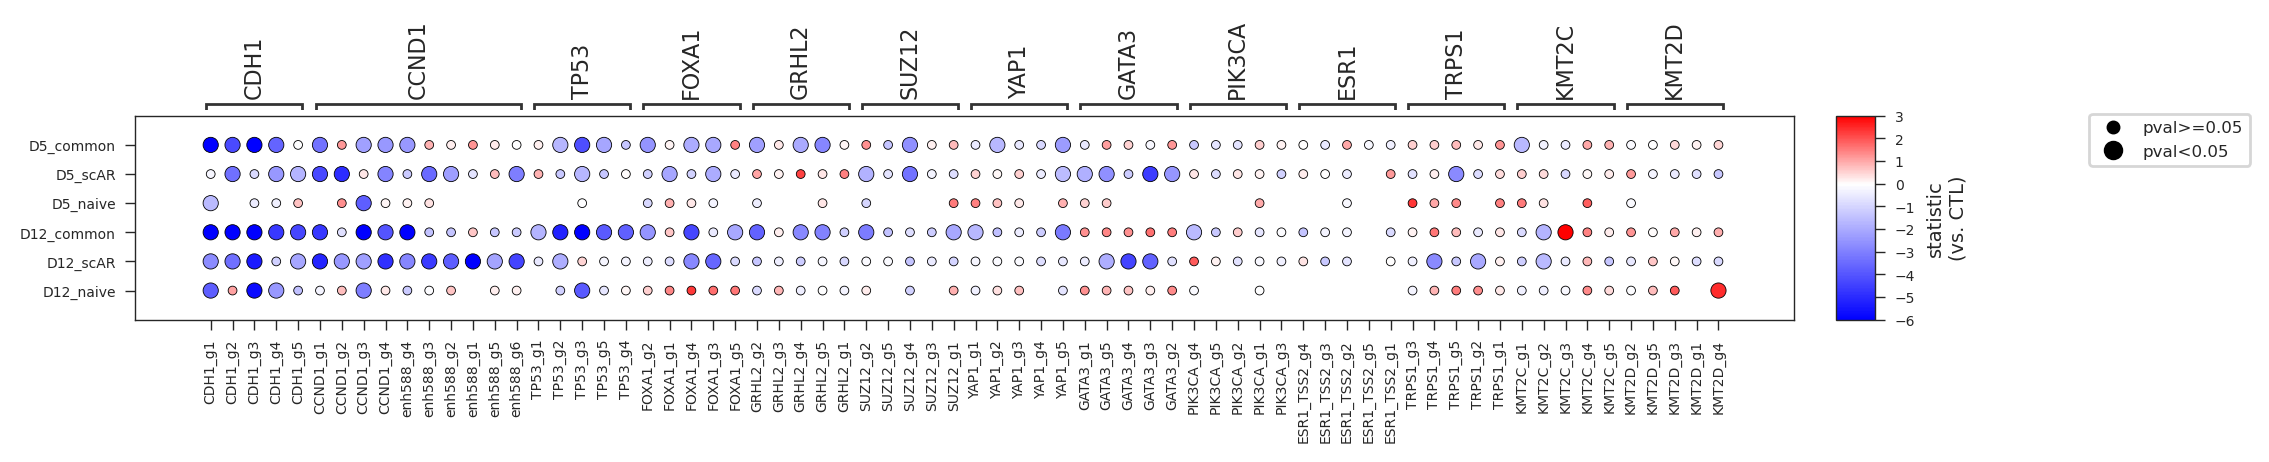

In [51]:
dotplot(DE_all_df, 'statistic', color_lim=[-6, 3])
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/Fig2_On_target_effect_dot_plot_z_normalization.pdf')

In [52]:
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib
from matplotlib.lines import Line2D
import matplotlib as mpl

def dotplot_cell_number(DE_matrix_df, col='cell number', color_lim=None):
    
    data_to_plot = DE_matrix_df[col]    
    vals = data_to_plot.values.flatten()
    vals = np.array(vals, dtype='float64')
    if color_lim is None:
        max_val = np.nanmax(vals)
        min_val = np.nanmin(vals)
    elif type(color_lim) == list:
        min_val, max_val = color_lim
    
    cell_number_mask = DE_matrix_df['cell number'].fillna(0).copy()
    cell_number_mask = cell_number_mask.mask(DE_matrix_df['cell number'] > 0, 2)
    cell_number_mask = cell_number_mask.mask(DE_matrix_df['cell number'] >= 10, 10)
    cell_number_mask = cell_number_mask.mask(DE_matrix_df['cell number'] >= 50, 15)
    cell_number_mask = cell_number_mask.mask(DE_matrix_df['cell number'] > 100, 20)
    sizes = list(cell_number_mask.values.flatten())

    offset = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=2., vmax=max_val);
    colors= offset(vals)
    cmap = matplotlib.cm.Spectral

    width = 12
    height = 2
    heatmap_width = 85
    colorbar_width = 2
    # colorbar_width_spacer = 5
    # size_legend_width = 5
    dotplot_height=0.95
    label_height = 0.05

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(bottom=0.2,top=0.75,right=0.85)
    axs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.05,hspace=0.05, #left=0.05, right=0.48, 
                            width_ratios=[heatmap_width, colorbar_width], #, colorbar_width_spacer, size_legend_width
                            height_ratios=[label_height, dotplot_height],)
    dot_ax = fig.add_subplot(axs[1,0])

    x, y = np.indices(data_to_plot.shape)
    y = y.flatten()
    x = x.flatten()
    dot_ax.scatter(x, y, c=colors, cmap='Greens', marker='s', s = sizes, edgecolor='black',lw=0.2) #vals, 
    plt.ylim(-1,6);
    plt.yticks(np.arange(6),data_to_plot.columns);
    # dot_ax.xaxis.tick_top()
    plt.xticks(np.arange(DE_all_df.shape[0]),DE_matrix_df.index,rotation=90);

    # plot size legend
    custom_lines = [Line2D([], [], marker='s',color="g", linestyle='None',markersize=1),
                    Line2D([], [], marker='s',color="g", linestyle='None',markersize=2),
                    Line2D([], [], marker='s',color="g", linestyle='None',markersize=3),
                    Line2D([], [], marker='s',color="g", linestyle='None',markersize=4)]
    dot_ax.legend(custom_lines, ['~10','10~50', '50~100', '100~'], bbox_to_anchor=(1.28,1.05), title='cell number', loc='upper right',fontsize=6)

    # add group labels
    codes, cats = pd.factorize(DE_matrix_df["target_genes"])
    var_group_labels = cats.tolist()
    var_group_positions = []
    pos = np.unique(codes,return_index = True)[1]
    end = np.append(pos[1:]-1,len(DE_matrix_df["target_genes"])-1)
    for s,e in zip(pos,end):
        var_group_positions.append((s,e))

    gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
    _plot_gene_groups_brackets(
        gene_groups_ax,
        group_positions=var_group_positions,
        group_labels=var_group_labels,
        rotation="vertical",
    )

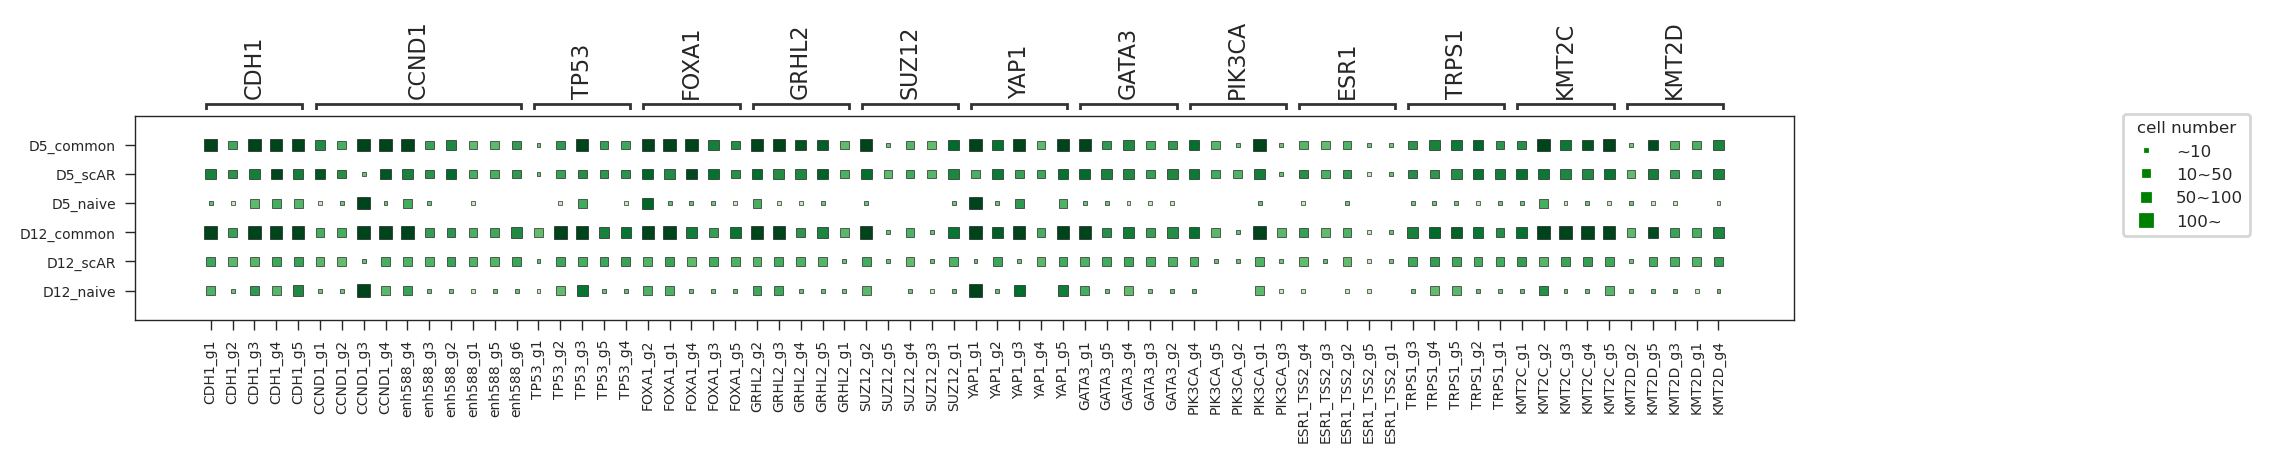

In [53]:
dotplot_cell_number(DE_all_df, col='cell number', color_lim=[0, 100])
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/Fig2_cell_number_dot_plot.pdf')

### Dropout experiment

In [54]:
dropout = pd.read_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/dropout_results.pickle')
dropout = dropout.rename_axis('sgRNAs')

In [55]:
DE_all_df1 = DE_all_df.copy()
DE_all_df1.columns = DE_all_df1.columns.to_flat_index().str.join('_').str.strip('_')
DE_all_df1 = DE_all_df1.join(dropout[['growth_rate', 'pval']], how='left', rsuffix='_deep_sequencing')
DE_all_df1.rename(columns={'growth_rate':'fitness score', 'pval':'fitness score_pval'}, inplace=True)

In [56]:
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib
from matplotlib.lines import Line2D
import matplotlib as mpl

def dotplot_growth_rate(DE_matrix_df):
        
    data_to_plot = DE_matrix_df['fitness score']
    vals = data_to_plot.values.flatten()
    vals = np.array(vals,dtype='float64')
    max_val = np.nanmax(vals)
    min_val = np.nanmin(vals)

    pvals = DE_matrix_df['fitness score_pval'].values.flatten()
    sizes = [30 if pval <0.05 else 10 for pval in pvals]

    offset = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=0., vmax=max_val);
    colors= offset(vals)
    cmap = matplotlib.cm.PiYG

    width = 12
    height = 2
    heatmap_width = 85
    colorbar_width = 2
    # colorbar_width_spacer = 5
    # size_legend_width = 5
    dotplot_height=0.95
    label_height = 0.05

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(bottom=0.2,top=0.75,right=0.85)
    axs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.05,hspace=0.05, #left=0.05, right=0.48, 
                            width_ratios=[heatmap_width, colorbar_width], #, colorbar_width_spacer, size_legend_width
                            height_ratios=[label_height, dotplot_height],)
    dot_ax = fig.add_subplot(axs[1,0])

    x, y = np.indices(DE_matrix_df[['fitness score']].shape)
    y = y.flatten()
    x = x.flatten()
    dot_ax.scatter(x, y, c=colors, cmap=cmap, s = sizes, marker='s', edgecolor='black',lw=0.2)#
    plt.ylim(-0.5,0.5);
    plt.yticks(np.arange(1),["bulk\nsequencing"]);
    # dot_ax.xaxis.tick_top()
    plt.xticks(np.arange(DE_matrix_df.shape[0]),DE_matrix_df.index,rotation=90);

    # plot size legend
    custom_lines = [Line2D([], [], marker='s',color="k", linestyle='None',markersize=4),
                    Line2D([], [], marker='s',color="k", linestyle='None',markersize=6)]
    dot_ax.legend(custom_lines, ['pval>=0.05','pval<0.05'], bbox_to_anchor=(1.28,1.05), title=None, loc='upper right',fontsize=6)

    # add group labels
    codes, cats = pd.factorize(DE_matrix_df["target_genes"])
    var_group_labels = cats.tolist()
    var_group_positions = []
    pos = np.unique(codes,return_index = True)[1]
    end = np.append(pos[1:]-1,len(DE_matrix_df["target_genes"])-1)
    for s,e in zip(pos,end):
        var_group_positions.append((s,e))

    gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
    _plot_gene_groups_brackets(
        gene_groups_ax,
        group_positions=var_group_positions,
        group_labels=var_group_labels,
        rotation="vertical",
    )

    # plot colorbar
    cbar = fig.add_subplot(axs[1, 1])
    plt.setp(cbar.spines.values(), linewidth=0.5)
    norm = MidpointNormalize(vmin=min_val, midpoint=0, vmax=max_val) #vmin=-0.4, vcenter=0., vmax=0.4
    matplotlib.colorbar.ColorbarBase(cbar, cmap=cmap, orientation='vertical',
                                     norm=norm,
                                    drawedges=False, 
                                    boundaries=None)
    cbar.set_ylabel("fitness score", fontsize=7);

/da/onc/bfx/research/shengca1/tools/anaconda3/envs/cropseq/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


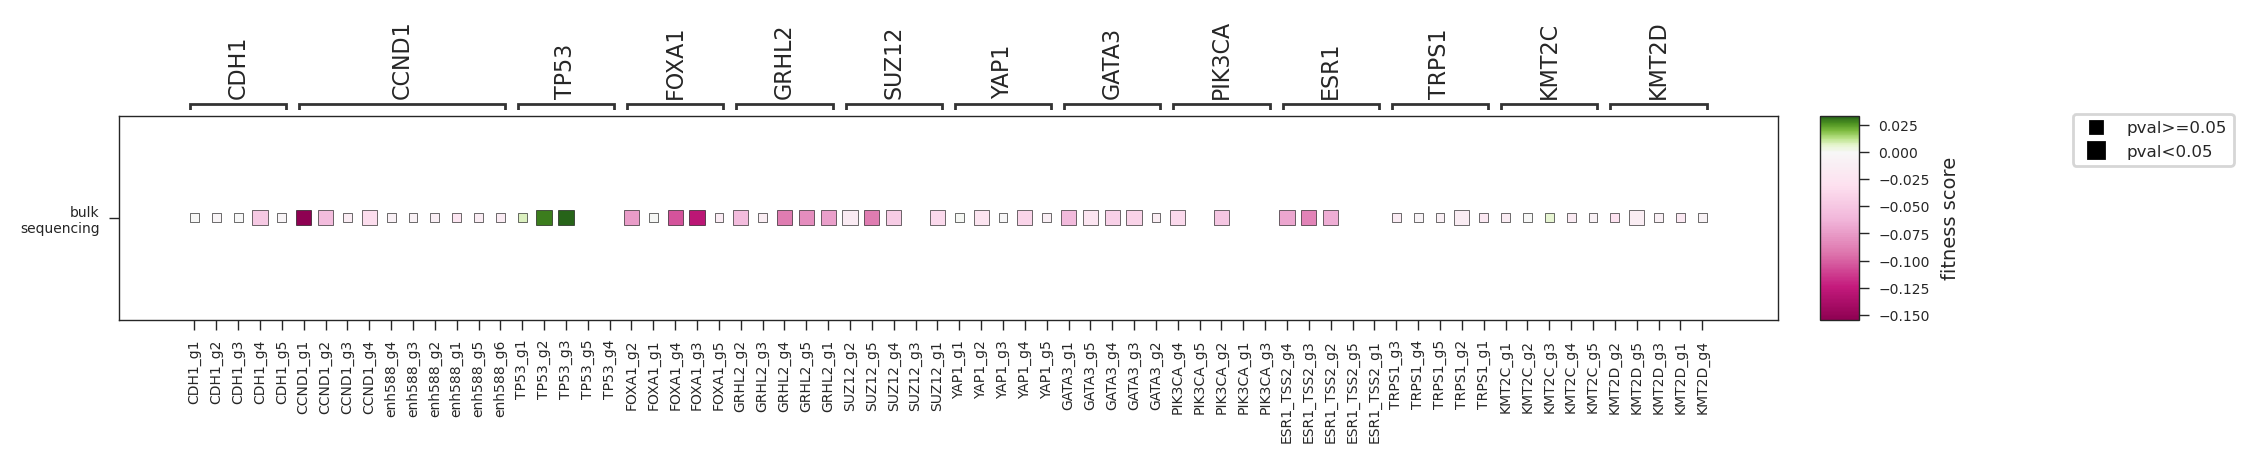

In [57]:
dotplot_growth_rate(DE_all_df1)
# plt.savefig('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/Fig2_On_fitness_score_plot.pdf', doi=200)

## Selected examples

### Processing CROPseq_val dataset

In [58]:
expression_mat_assignment = pd.read_pickle('/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/data/CROPseq_val/expression_matrix_sgRNA_assigned.pickle')
assignment_df = pd.DataFrame()

for sample, row in metadata.iterrows():
    
    sgRNA_assign_real_cells = pd.read_pickle(row['count_matrix'])
    scar_pval = pd.read_pickle(os.path.join(row['scAR_out'], 'probs.pickle'))

    ass = scar_pval.join(sgRNA_assign_real_cells, rsuffix='_naive')
    ass['time_points'] = row['condition1']
    ass['replicates'] = row['condition2']
    assignment_df = ass.append(assignment_df)

assignment_df.index = assignment_df['time_points'].astype(str) + '_' + assignment_df['replicates'].astype(str) +  '_' + assignment_df.index.astype(str) + '-1'
assignment_df = assignment_df.rename_axis('cells')

In [59]:
color_dict = {"orange": (0.90, 0.60, 0.0),
              "skyblue": (0.35, 0.70, 0.90),
              "bluishgreen": (0.0, 0.60, 0.50),
              "yellow": (0.95, 0.90, 0.25),
              "blue": (0.0, 0.45, 0.70),
              "vermillion": (0.80, 0.40, 0.0),
              "reddishpurple": (0.80, 0.60, 0.70),
             }

In [60]:
color_dict = {"orange": (0.90, 0.60, 0.0),
              "skyblue": (0.35, 0.70, 0.90),
              "bluishgreen": (0.0, 0.60, 0.50),
              "yellow": (0.95, 0.90, 0.25),
              "blue": (0.0, 0.45, 0.70),
              "vermillion": (0.80, 0.40, 0.0),
              "reddishpurple": (0.80, 0.60, 0.70),
             }

### FOXA1_g3

In [61]:
assignment_FOXA1_g3 = assignment_df[['FOXA1_g3', 'FOXA1_g3_naive']].join(expression_mat_assignment[['time_points',
                                                                                                    'replicates',
                                                                                                    'FOXA1',
                                                                                                    'sgRNAs_naive',
                                                                                                    'sgRNAs_scAR',
                                                                                                    'groups_naive',
                                                                                                    'groups_scAR',
                                                                                                    ]], how='left')
assignment_FOXA1_g3.rename(columns = {'FOXA1_g3': 'probability',
                                         'FOXA1_g3_naive':'fraction of counts',
                                         'FOXA1': 'FOXA1 counts',
                                         'sgRNAs_naive': 'naive',
                                         'sgRNAs_scAR': 'scAR'},
                                         inplace=True)

assignment_FOXA1_g3['FOXA1_g3_assignment'] = 'other'

for cell, row in assignment_FOXA1_g3.iterrows():
    if (row['naive'] == 'FOXA1_g3') & (row['scAR'] == 'FOXA1_g3'):
        assignment_FOXA1_g3.loc[cell, 'FOXA1_g3_assignment'] = 'naive ∩ scar'    
    elif (row['naive'] == 'FOXA1_g3') & (row['scAR'] != 'FOXA1_g3'):
        assignment_FOXA1_g3.loc[cell, 'FOXA1_g3_assignment'] = 'naive'    
    elif (row['naive'] != 'FOXA1_g3') & (row['scAR'] == 'FOXA1_g3'):
        assignment_FOXA1_g3.loc[cell, 'FOXA1_g3_assignment'] = 'scar'    
    elif (row['naive'] != 'FOXA1_g3') & (row['scAR'] != 'FOXA1_g3'):
        assignment_FOXA1_g3.loc[cell, 'FOXA1_g3_assignment'] = 'other'

assignment_FOXA1_g3

,probability,fraction of counts,time_points,replicates,FOXA1 counts,naive,scAR,groups_naive,groups_scAR,FOXA1_g3_assignment
cells,,,,,,,,,,
D12_R3_AAACCTGAGACTAAGT-1,0.730737,2.0,D12,R3,1.999324,CTRL_g15,CTRL_g15,CTL,CTL,other
D12_R3_AAACCTGAGAGTGAGA-1,0.342434,0.0,D12,R3,0.000000,NaN,KMT2C_g5,NaN,KMT2C,other
D12_R3_AAACCTGAGGCATGTG-1,0.739241,0.0,D12,R3,1.258002,YAP1_g1,TRPS1_g4,YAP1,TRPS1,other
D12_R3_AAACCTGCAATGGAAT-1,0.683982,1.0,D12,R3,0.000000,KMT2C_g4,KMT2C_g4,KMT2C,KMT2C,other
D12_R3_AAACCTGCACGACGAA-1,0.872659,2.0,D12,R3,1.766022,ESR1_TSS1_g5,ESR1_TSS1_g5,ESR1_TSS1,ESR1_TSS1,other
...,...,...,...,...,...,...,...,...,...,...
D5_R1_TTTGTCAGTTCTGGTA-1,0.905887,2.0,D5,R1,1.921905,CTRL_g2,CTRL_g2,CTL,CTL,other
D5_R1_TTTGTCAGTTGACGTT-1,0.207478,0.0,D5,R1,0.000000,TRPS1_g1,TRPS1_g1,TRPS1,TRPS1,other
D5_R1_TTTGTCATCACCATAG-1,0.652677,1.0,D5,R1,2.588058,TRPS1_g1,TRPS1_g1,TRPS1,TRPS1,other


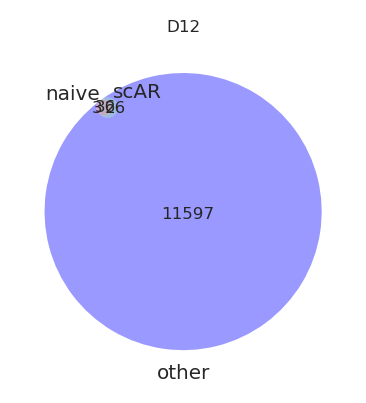

In [62]:
from matplotlib_venn import venn3, venn2

plt.figure(figsize=(6,2))

for i, tp in enumerate(['D5' , 'D12']):
    if i == 1:
        sub_df = assignment_FOXA1_g3[assignment_FOXA1_g3['time_points']==tp].reset_index()
        set_all = set(sub_df['cells'])
        set_naive = set(sub_df[sub_df['naive']=='FOXA1_g3']['cells'])
        set_scar = set(sub_df[sub_df['scAR']=='FOXA1_g3']['cells'])

        plt.subplot(1, 2, i+1)
        venn3([set_naive, set_scar, set_all], ('naive', 'scAR', 'other'))
        plt.title(tp)
    
# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/CROPSeq_Lopes2021_Wenn.pdf', doi=200)

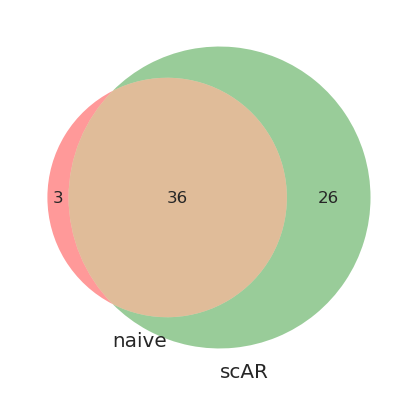

In [63]:
venn2([set_naive, set_scar], ('naive', 'scAR'));
# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/CROPSeq_val_Wenn_FOXA1_g3.pdf', doi=200)

[(-2.0, 7.0), Text(0, 0.5, 'log(FOXA1 UMIs+1)'), Text(0.5, 0, 'cell groups')]

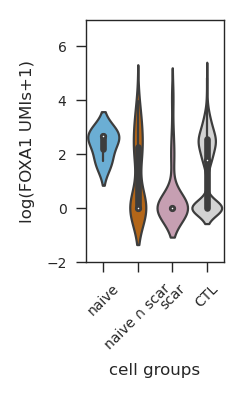

In [64]:
sub_df = assignment_FOXA1_g3[assignment_FOXA1_g3['time_points']=='D12'].reset_index()
sub_df.loc[(sub_df['groups_naive']== 'CTL') & (sub_df['groups_scAR']== 'CTL'), 'FOXA1_g3_assignment'] = 'CTL'

plt.figure(figsize=(1.2,2))
g = sns.violinplot(data=sub_df,
                x='FOXA1_g3_assignment',
                y='FOXA1 counts',
                order=['naive', 'naive ∩ scar', 'scar', 'CTL'],
                palette=[color_dict['skyblue'], color_dict['vermillion'],color_dict['reddishpurple'],'lightgray'],
                width=0.9, 
                linewidth=0.8,
                fliersize=1
               )
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set(ylim=(-2,7), ylabel='log(FOXA1 UMIs+1)', xlabel='cell groups')

# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/CROPSeq_val_D12_FOXA1_g3_violinplot.pdf', doi=200)

### FOXA1_g2

In [65]:
assignment_FOXA1_g2 = assignment_df[['FOXA1_g2', 'FOXA1_g2_naive']].join(expression_mat_assignment[['time_points', 
                                                                                        'replicates', 
                                                                                        'FOXA1', 
                                                                                        'sgRNAs_naive', 
                                                                                        'sgRNAs_scAR', 
                                                                                        'groups_naive', 
                                                                                        # 'target_genes_naive', 
                                                                                        'groups_scAR', 
                                                                                        # 'target_genes_scar',
                                                                                                   ]], how='left')
assignment_FOXA1_g2.rename(columns = {'FOXA1_g2': 'probability',
                                         'FOXA1_g2_naive':'fraction of counts', 
                                         'FOXA1': 'FOXA1 counts',
                                         'sgRNAs_naive': 'naive',
                                         'sgRNAs_scAR': 'scAR'},
                                         inplace=True)

assignment_FOXA1_g2['FOXA1_g2_assignment'] = 'other'

for cell, row in assignment_FOXA1_g2.iterrows():
    if (row['naive'] == 'FOXA1_g2') & (row['scAR'] == 'FOXA1_g2'):
        assignment_FOXA1_g2.loc[cell, 'FOXA1_g2_assignment'] = 'naive ∩ scar'    
    elif (row['naive'] == 'FOXA1_g2') & (row['scAR'] != 'FOXA1_g2'):
        assignment_FOXA1_g2.loc[cell, 'FOXA1_g2_assignment'] = 'naive'    
    elif (row['naive'] != 'FOXA1_g2') & (row['scAR'] == 'FOXA1_g2'):
        assignment_FOXA1_g2.loc[cell, 'FOXA1_g2_assignment'] = 'scar'    
    elif (row['naive'] != 'FOXA1_g2') & (row['scAR'] != 'FOXA1_g2'):
        assignment_FOXA1_g2.loc[cell, 'FOXA1_g2_assignment'] = 'other'

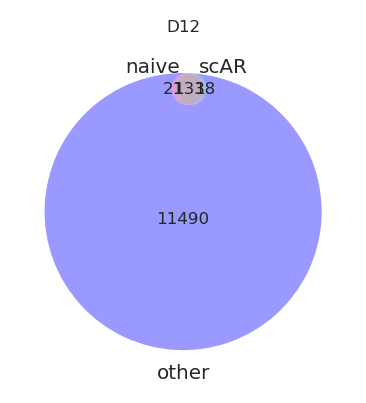

In [66]:
from matplotlib_venn import venn3, venn2

plt.figure(figsize=(6,2))

for i, tp in enumerate(['D5' , 'D12']):
    if i == 1:
        sub_df = assignment_FOXA1_g2[assignment_FOXA1_g2['time_points']==tp].reset_index()
        set_all = set(sub_df['cells'])
        set_naive = set(sub_df[sub_df['naive']=='FOXA1_g2']['cells'])
        set_scar = set(sub_df[sub_df['scAR']=='FOXA1_g2']['cells'])

        plt.subplot(1, 2, i+1)
        venn3([set_naive, set_scar, set_all], ('naive', 'scAR', 'other'))
        plt.title(tp)
    
# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/CROPSeq_Lopes2021_Wenn.pdf', doi=200)

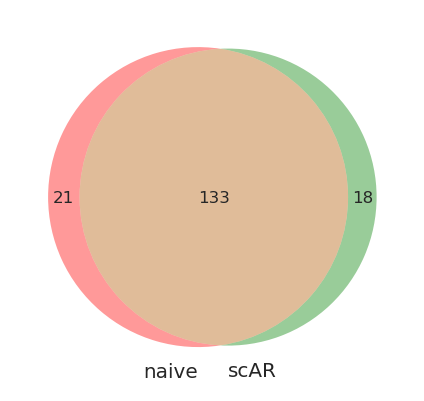

In [67]:
venn2([set_naive, set_scar], ('naive', 'scAR'));
# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/CROPSeq_FOXA1_g2.pdf', doi=200)

[(-2.0, 7.0), Text(0, 0.5, 'log(FOXA1 UMIs+1)'), Text(0.5, 0, 'cell groups')]

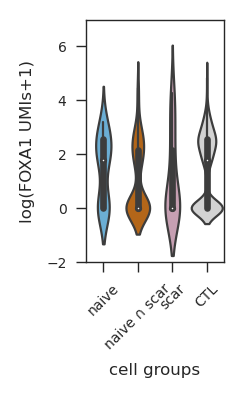

In [68]:
sub_df = assignment_FOXA1_g2[assignment_FOXA1_g2['time_points']=='D12'].reset_index()
sub_df.loc[(sub_df['groups_naive']== 'CTL') & (sub_df['groups_scAR']== 'CTL'), 'FOXA1_g2_assignment'] = 'CTL'

plt.figure(figsize=(1.2,2))
g = sns.violinplot(data=sub_df,
                x='FOXA1_g2_assignment',
                y='FOXA1 counts',
                order=['naive', 'naive ∩ scar', 'scar', 'CTL'],
                palette=[color_dict['skyblue'], color_dict['vermillion'],color_dict['reddishpurple'],'lightgray'],
                width=0.9, 
                linewidth=0.8,
                fliersize=1
               )
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set(ylim=(-2,7), ylabel='log(FOXA1 UMIs+1)', xlabel='cell groups')

# plt.savefig(f'/da/ONC/BFx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/Fig2_CROP-seq_val/CROPSeq_val_D12_FOXA1_boxplot.pdf', doi=200)